In [1]:
!pip install tensorflow
#Install Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import os
import shutil
from sklearn.model_selection import train_test_split
import time

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


2025-01-16 21:05:31.017674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 21:05:31.807290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pip install gputil

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7412 sha256=c414daeec41ffffe3b245ac0d10b3140896f9e71cbf6e76d638c9f28fe4e654c
  Stored in directory: /home/riset/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import time
import psutil
import GPUtil

# Logging perangkat keras
def log_device_info():
    print("=== Device Information ===")
    device = "CPU"
    if tf.config.list_physical_devices('GPU'):
        gpu_devices = GPUtil.getGPUs()
        for gpu in gpu_devices:
            print(f"GPU: {gpu.name}, Memory: {gpu.memoryTotal}MB")
        device = gpu_devices[0].name if gpu_devices else "Unknown GPU"
    else:
        print("Using CPU only")
    print("==========================")
    return device

# Logging performa (memori, waktu, dsb.)
def log_performance(start_time):
    end_time = time.time()
    memory_info = psutil.virtual_memory()
    print("\n=== Performance Metrics ===")
    print(f"Execution Time: {end_time - start_time:.2f} seconds")
    print(f"Memory Usage: {memory_info.percent}%")
    print("==========================")

In [4]:
import tensorflow as tf

print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import os
print("Direktori kerja saat ini:", os.getcwd())

Direktori kerja saat ini: /drive0-storage/RINA_S3


In [6]:
import os
print("Isi folder saat ini:", os.listdir(os.getcwd()))

Isi folder saat ini: ['zoom_eng', '.ipynb_checkpoints', 'dataset_dgxcek', 'labelled', 'eng_gp.ipynb']


In [5]:
#Load Dataset
engaged_path = os.path.join('labelled/engaged')
disengaged_path = os.path.join('labelled/disengaged')

In [6]:
#Create folder for training and testing
output_path = 'dataset_dgxcek'
train_path = os.path.join(output_path, 'train')
test_path = os.path.join(output_path, 'test')

os.makedirs(os.path.join(train_path, 'engaged'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'disengaged'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'engaged'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'disengaged'), exist_ok=True)

In [42]:
import os
import shutil
from sklearn.model_selection import train_test_split
import time

def split_data(source, train_dest, test_dest, test_size=0.2):
    """
    Splits data into train and test sets and copies files to respective folders.
    Introduces a delay to mitigate potential I/O errors on Google Colab.
    """
    for i in range(3):  # retry up to 3x
        try:
            files = os.listdir(source)
            break  # exit loop if successful
        except OSError as e:
            if i < 2:  # not the last attempt
                print(f"Percobaan ke-{i+1} gagal dengan error: {e}")
                print("Coba ulang setelah delay...")
                time.sleep(5)  # tunggu 5 detik sebelum mencoba lagi
            else:
                raise e  # re-raise the exception if all attempts fail

    # Split data into train and test
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Buat folder tujuan jika belum ada
    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    # Move files to train folder
    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train_dest, file))

    # Move files to test folder
    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test_dest, file))

In [43]:
split_data(engaged_path, os.path.join(train_path, 'engaged'), os.path.join(test_path, 'engaged'))
split_data(disengaged_path, os.path.join(train_path, 'disengaged'), os.path.join(test_path, 'disengaged'))

In [8]:
import os
print("Isi folder saat ini:", os.listdir(os.getcwd()))

Isi folder saat ini: ['zoom_eng', '.ipynb_checkpoints', 'dataset_dgxcek', 'labelled', 'eng_gp.ipynb']


In [17]:
#checking training n testing folder
train_path = "dataset_dgxcek/train"
test_path = "dataset_dgxcek/test"

In [18]:
#check random img

import matplotlib.pyplot as plt

x = plt.imread("dataset_dgxcek/train/engaged/peserta8_9448.jpg")
x.shape

(180, 320, 3)

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [20]:
train = datagen.flow_from_directory(train_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale", batch_size=128)
test = datagen.flow_from_directory(test_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale", batch_size=128)

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.


In [21]:
dir(train)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 '_warn_if_super_not_called',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'keep_aspect_ratio',
 'labels',
 'lock',
 'max_queue_size',
 'n',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 

In [22]:
print(train.class_indices)
emotion_dict = {0: "Engaged", 1: "Disengaged"}

{'disengaged': 0, 'engaged': 1}


In [23]:
# Use __next__() instead of next()
x, y = train.__next__()
print(x.shape, y.shape)
train.reset()

(128, 48, 48, 1) (128,)


In [24]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(48,48,1),padding="same"),
    LeakyReLU(),
    Conv2D(32, (3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(64,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),
#     Dense(64, activation="relu"),

    Dense(len(train.class_indices), activation="softmax")
])
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/home/riset/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,025,122 (3.91 MB)

 Trainable params: 1,024,674 (3.91 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
net = Sequential(name='DCNN')

net.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(48, 48, 1),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
net.add(BatchNormalization(name='batchnorm_1'))
net.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
net.add(BatchNormalization(name='batchnorm_2'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
net.add(Dropout(0.4, name='dropout_1'))

net.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
net.add(BatchNormalization(name='batchnorm_3'))
net.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
net.add(BatchNormalization(name='batchnorm_4'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
net.add(Dropout(0.4, name='dropout_2'))

net.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
net.add(BatchNormalization(name='batchnorm_5'))
net.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
net.add(BatchNormalization(name='batchnorm_6'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
net.add(Dropout(0.5, name='dropout_3'))

net.add(Flatten(name='flatten'))

net.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
net.add(BatchNormalization(name='batchnorm_7'))

net.add(Dropout(0.6, name='dropout_4'))

net.add(
    Dense(
        7,
        activation='softmax',
        name='out_layer'
    )
)

net.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

net.summary()

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [28]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"Device: {gpu}")
else:
    print("No GPU available")

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [29]:
import tensorflow as tf

# Check CUDA version via TensorFlow
cuda_version = tf.sysconfig.get_build_info()["cuda_version"]
cudnn_version = tf.sysconfig.get_build_info()["cudnn_version"]

print(f"CUDA Version: {cuda_version}")
print(f"cuDNN Version: {cudnn_version}")

CUDA Version: 12.3
cuDNN Version: 8


In [30]:
import sys
print(f"Python Version: {sys.version}")
print(f"Python Version Info: {sys.version_info}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Python Version Info: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [31]:
import os
from PIL import Image

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Cek apakah gambar valid
            except (IOError, SyntaxError):
                print(f"File tidak valid: {file_path}")

# Validasi direktori dataset
validate_images('/labelled')

In [32]:
from PIL import Image

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifikasi integritas gambar
            except (IOError, SyntaxError) as e:
                print(f"Gambar rusak: {file_path}, Error: {e}")

# Verifikasi semua gambar
verify_images('dataset_dgxcek/train')

In [33]:
from PIL import Image

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifikasi integritas gambar
            except (IOError, SyntaxError) as e:
                print(f"Gambar rusak: {file_path}, Error: {e}")

# Verifikasi semua gambar
verify_images('dataset_dgxcek/test')

In [27]:
import os
from PIL import Image

def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifikasi integritas gambar
            except (IOError, SyntaxError):
                print(f"Menghapus gambar rusak: {file_path}")
                os.remove(file_path)

# Hapus gambar rusak di train dan test
remove_corrupted_images('dataset_dgxcek/train')
remove_corrupted_images('dataset_dgxcek/test')

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    'dataset_dgxcek/train',
    target_size=(150, 150),  # Sesuaikan ukuran gambar
    batch_size=32,
    class_mode='binary'
)

Found 49777 images belonging to 2 classes.


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    'dataset_dgxcek/test',
    target_size=(150, 150),  # Sesuaikan ukuran gambar
    batch_size=32,
    class_mode='binary'
)


Found 12446 images belonging to 2 classes.


In [36]:
import os

def verify_dataset(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.exists(file_path):
                print(f"File tidak ditemukan: {file_path}")

# Verifikasi dataset train dan test
verify_dataset('dataset_dgxcek/train')
verify_dataset('dataset_dgxcek/test')

In [72]:
tf.keras.backend.clear_session()

In [ ]:
# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()#train
history = model.fit(train, validation_data=test, epochs=200, callbacks=callbacks)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/200


/home/riset/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - accuracy: 0.8028 - loss: 0.5842 - val_accuracy: 0.3602 - val_loss: 1.1301 - learning_rate: 1.0000e-04
Epoch 2/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.8729 - loss: 0.3389 - val_accuracy: 0.9115 - val_loss: 0.2516 - learning_rate: 1.0000e-04
Epoch 3/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.8992 - loss: 0.2805 - val_accuracy: 0.9210 - val_loss: 0.2258 - learning_rate: 1.0000e-04
Epoch 4/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.9172 - loss: 0.2430 - val_accuracy: 0.9282 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 5/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9220 - loss: 0.2246 - val_accuracy: 0.9369 - val_loss: 0.1813 - learning_rate: 1.0000e-04
Epoch 6/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - accuracy: 0.9282 - loss: 0.2041 - val_accuracy: 0.9414 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 7/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - 

In [36]:
model.save('modelbaselineawal_dgx.h5')

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,074,472 (11.73 MB)

 Trainable params: 1,024,674 (3.91 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2,049,350 (7.82 MB)

In [37]:
#install pydot to visualize model

!pip install pydot

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [38]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 197.0 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
from tensorflow.keras.utils import plot_model


# Visualize the model
plot_model(model,to_file='my_model.png',show_shapes=False, rankdir="LR")

# Visualize the Model showing the input and output shapes
#plot_model(model,to_file='my_model.png',show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [40]:
# Replace `test.next()` with `next(test)`
x, y = next(test)
preds = model.predict(x)
idx = np.argmax(preds, axis=1)
print('correct prediction:', np.sum((y == idx) * 1) / 128)

I0000 00:00:1737036864.006971     204 service.cc:145] XLA service 0x7f26ec002240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737036864.007022     204 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 7g.40gb, Compute Capability 8.0
2025-01-16 21:14:24.024550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-16 21:14:25.687523: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
correct prediction: 0.3828125


I0000 00:00:1737036867.314036     204 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [41]:
preds = model.predict(x[:1])
np.argmax(preds, axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


array([1])

In [43]:
img = x[0]
res = np.array([img])

In [44]:
model.predict(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[7.9428375e-09, 1.0000000e+00]], dtype=float32)

In [45]:
print("y values (label sebenarnya):", y[:10])
print("Kategori y:", [emotion_dict[label] for label in y[:10]])

y values (label sebenarnya): [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
Kategori y: ['Disengaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Engaged', 'Disengaged', 'Disengaged', 'Disengaged']


In [46]:
print(train.class_indices)
emotion_dict = {1: "Engaged", 0: "Disengaged"}

{'disengaged': 0, 'engaged': 1}


In [47]:
print("y values (label sebenarnya):", y[:10])
print("Kategori y:", [emotion_dict[label] for label in y[:10]])

y values (label sebenarnya): [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
Kategori y: ['Engaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Disengaged', 'Engaged', 'Engaged', 'Engaged']


In [48]:
for i in range(10):  # Lihat 10 sampel pertama
    print(f"Sample {i+1}: Label={emotion_dict[y[i]]}, Prediksi={emotion_dict[idx[i]]}")

Sample 1: Label=Engaged, Prediksi=Engaged
Sample 2: Label=Engaged, Prediksi=Engaged
Sample 3: Label=Engaged, Prediksi=Engaged
Sample 4: Label=Engaged, Prediksi=Engaged
Sample 5: Label=Engaged, Prediksi=Engaged
Sample 6: Label=Engaged, Prediksi=Engaged
Sample 7: Label=Disengaged, Prediksi=Disengaged
Sample 8: Label=Engaged, Prediksi=Engaged
Sample 9: Label=Engaged, Prediksi=Engaged
Sample 10: Label=Engaged, Prediksi=Engaged


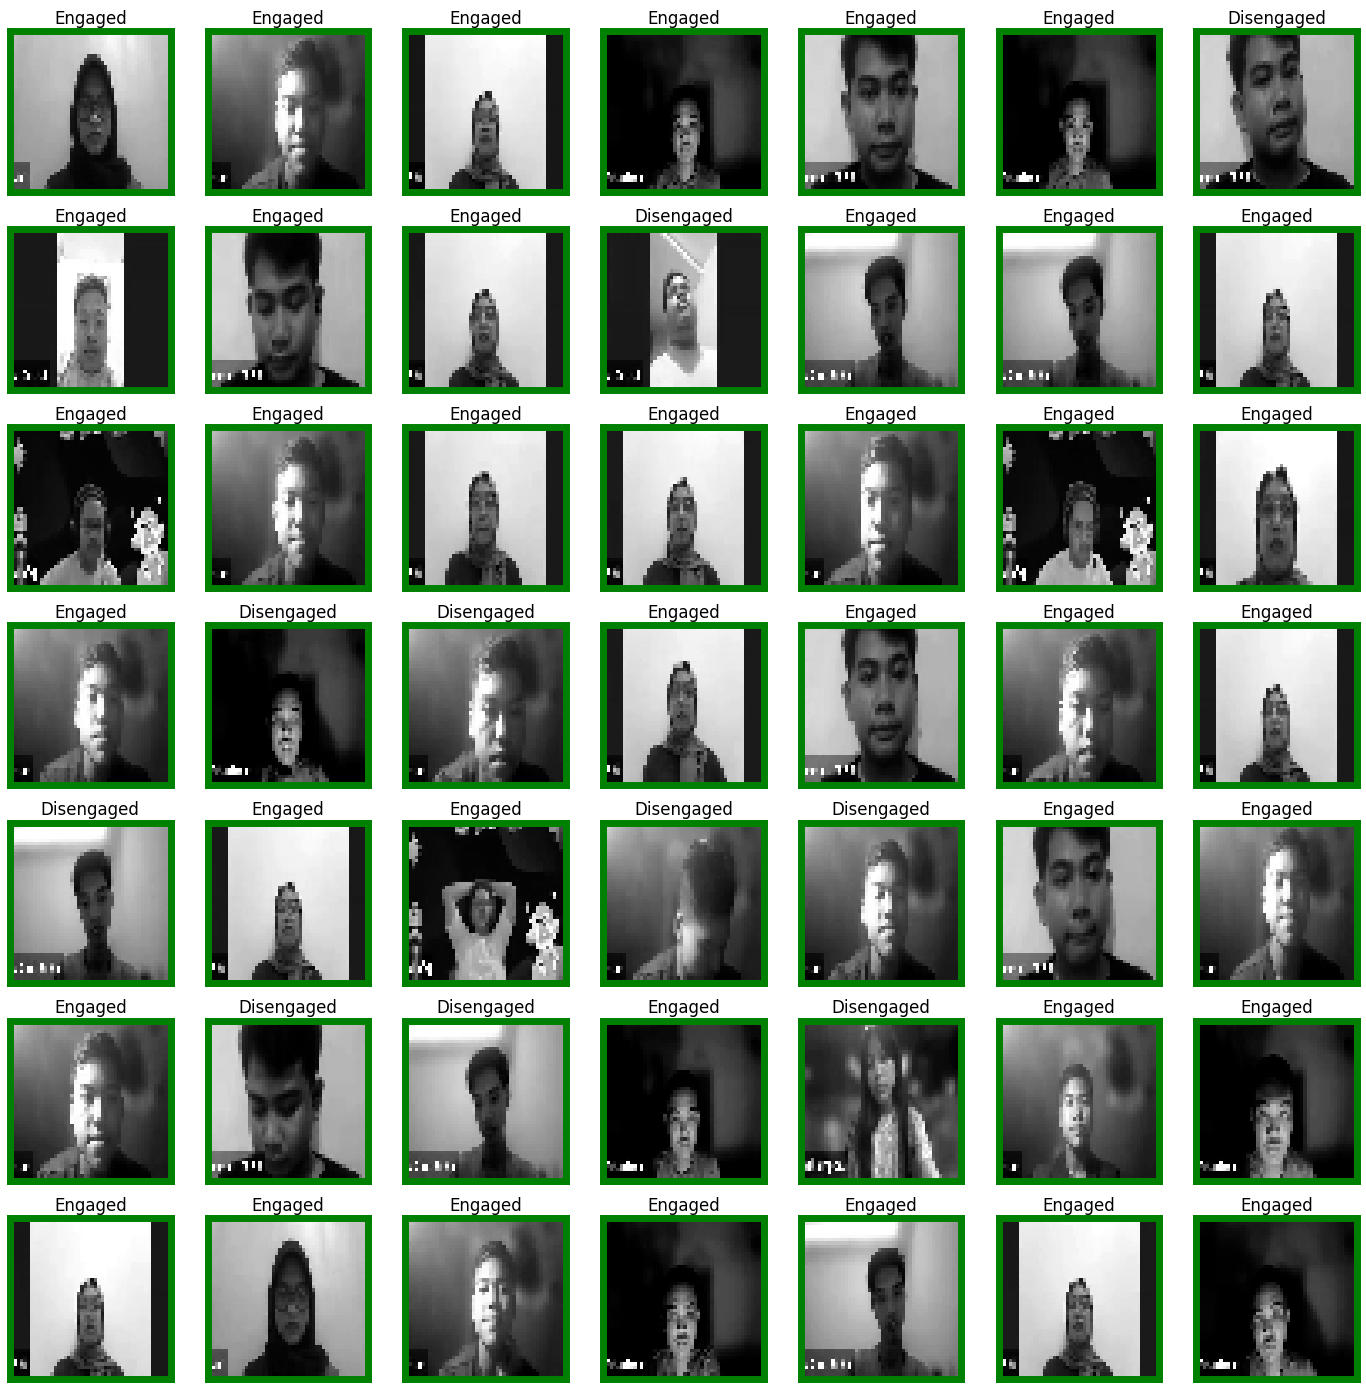

In [49]:
fig = plt.figure(1, (14, 14))

k = 0
# Batasi jumlah gambar yang ditampilkan menjadi maksimal 49
for j in range(min(len(x), 49)):  # Hanya tampilkan maksimal 49 gambar
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)  # Grid 7x7
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Cek apakah prediksi dan label benar
    if emotion_dict[y[j]] == emotion_dict[idx[j]]:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')  # Hijau jika prediksi benar
        ax.set_title(emotion_dict[idx[j]])
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')  # Merah jika prediksi salah
        ax.set_title('P:' + emotion_dict[idx[j]] + " C:" + emotion_dict[y[j]])

plt.tight_layout()
plt.show()

In [50]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [51]:
# Import library untuk evaluasi
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# --- Persiapan Dataset Uji --- #
# Path folder uji
test_path_engaged = os.path.join(test_path, 'engaged')
test_path_disengaged = os.path.join(test_path, 'disengaged')

# Muat gambar dari direktori uji
def load_test_images_and_labels():
    X_test = []
    y_test = []

    # Load gambar dari folder engaged
    for img_name in os.listdir(test_path_engaged):
        img_path = os.path.join(test_path_engaged, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        X_test.append(img)
        y_test.append(1)  # Label untuk engaged

    # Load gambar dari folder disengaged
    for img_name in os.listdir(test_path_disengaged):
        img_path = os.path.join(test_path_disengaged, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        X_test.append(img)
        y_test.append(0)  # Label untuk disengaged

    return np.array(X_test), np.array(y_test)

# Panggil fungsi untuk mendapatkan X_test dan y_test
X_test, y_test = load_test_images_and_labels()

print(f"Jumlah data uji: {len(X_test)}")

Jumlah data uji: 12446


In [52]:
print(model.input_shape)

(None, 48, 48, 1)


In [53]:
print(X_test.shape)

(12446, 224, 224, 3)


In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Path dataset uji
test_path_engaged = os.path.join(test_path, 'engaged')
test_path_disengaged = os.path.join(test_path, 'disengaged')

# Fungsi untuk memuat dan memproses gambar uji
def load_and_preprocess_test_images():
    X_test = []
    y_test = []

    # Muat gambar dari folder engaged
    for img_name in os.listdir(test_path_engaged):
        img_path = os.path.join(test_path_engaged, img_name)
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalisasi
        X_test.append(img)
        y_test.append(1)  # Label untuk engaged

    # Muat gambar dari folder disengaged
    for img_name in os.listdir(test_path_disengaged):
        img_path = os.path.join(test_path_disengaged, img_name)
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalisasi
        X_test.append(img)
        y_test.append(0)  # Label untuk disengaged

    return np.array(X_test), np.array(y_test)

# Muat dataset uji
X_test, y_test = load_and_preprocess_test_images()

# Periksa bentuk dataset
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_test: (12446, 48, 48, 1)
Shape y_test: (12446,)


In [55]:
# Prediksi dengan model
y_pred = model.predict(X_test)
print("Shape y_pred:", y_pred.shape)

# Konversi probabilitas ke kelas
if y_pred.shape[1] > 1:  # Jika multi-kelas
    y_pred_classes = np.argmax(y_pred, axis=1)
else:  # Jika biner
    y_pred_classes = (y_pred > 0.5).astype("int32")

# Periksa hasil prediksi
print("Shape y_pred_classes:", y_pred_classes.shape)
print("Sample y_pred_classes:", y_pred_classes[:5])

# Jika output berupa probabilitas multi-class, ambil indeks kelas dengan probabilitas tertinggi
#y_pred_classes = np.argmax(y_pred_classes, axis=1)

# Periksa kembali bentuk array
#print("Shape y_pred_classes setelah perbaikan:", y_pred_classes.shape)
#print("Sample y_pred_classes setelah perbaikan:", y_pred_classes[:5])

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape y_pred: (12446, 2)
Shape y_pred_classes: (12446,)
Sample y_pred_classes: [1 1 1 1 1]


In [56]:
# Evaluasi performa pada dataset validasi dengan logging hardware performance
import time
import psutil

# Mulai pencatatan waktu evaluasi
start_eval_time = time.time()
val_loss, val_accuracy = model.evaluate(X_test, y_test)
end_eval_time = time.time()

# Logging evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("===========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9947 - loss: 0.0189

=== Evaluation Metrics ===
Evaluation Time: 2.06 seconds
Validation Accuracy: 0.987947940826416
Validation Loss: 0.036836668848991394
Memory Usage: 58.4%


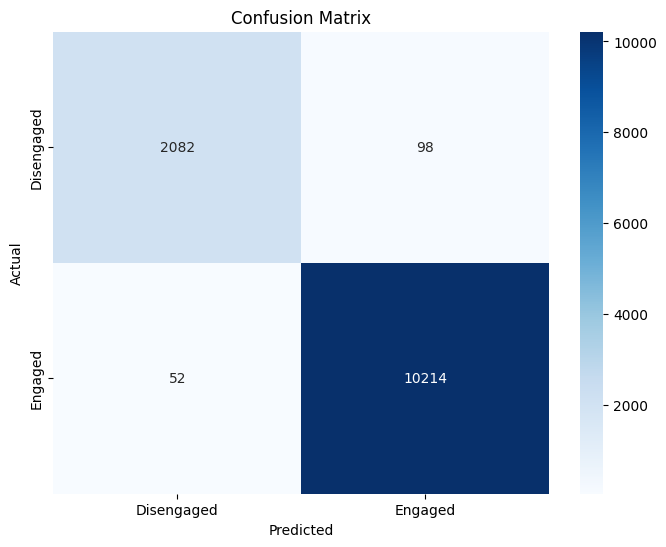

Classification Report:
              precision    recall  f1-score   support

  Disengaged       0.98      0.96      0.97      2180
     Engaged       0.99      0.99      0.99     10266

    accuracy                           0.99     12446
   macro avg       0.98      0.97      0.98     12446
weighted avg       0.99      0.99      0.99     12446



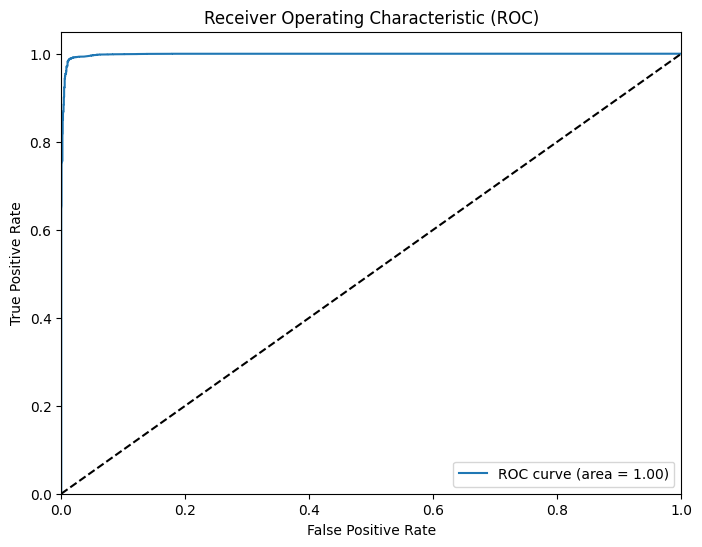

AUC Score: 1.00


In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# --- Confusion Matrix --- #
cm = confusion_matrix(y_test, y_pred_classes)
class_labels = ['Disengaged', 'Engaged']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- Classification Report --- #
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_labels))

# --- ROC Curve & AUC Score --- #
y_pred_prob = y_pred[:, 1]  # Ambil probabilitas untuk kelas positif (Engaged)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.2f}")

Train Ulang Model

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Training menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.


In [59]:
#validasi dataset di train_generator

print(f"Total training samples: {train_generator.samples}")
print(f"Total testing samples: {test_generator.samples}")

Total training samples: 49777
Total testing samples: 12446


In [61]:
#ubah dataset dari rgb ke grayscale

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Training dan Testing menggunakan ImageDataGenerator dalam mode Grayscale
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'  # Konversi gambar menjadi grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',  # Konversi gambar menjadi grayscale
    shuffle=False
)

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.


In [62]:
#periksa bentukan datasetnya

batch_X, batch_y = next(train_generator)
print("Shape of a batch from train_generator:", batch_X.shape)

Shape of a batch from train_generator: (32, 48, 48, 1)


In [63]:
#sesuaikan arsitektur buat binary classfctn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Arsitektur Model untuk Binary Classification
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),  # Sesuai dataset grayscale
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 1 neuron untuk klasifikasi biner
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Sesuai dengan output sigmoid
    metrics=['accuracy']
)

# Tampilkan Ringkasan Model
model.summary()

/home/riset/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 838,657 (3.20 MB)

 Trainable params: 838,465 (3.20 MB)

 Non-trainable params: 192 (768.00 B)

In [64]:
#bismillaah retraining

from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Latih ulang model
#history = model.fit(
#    train_generator,
#    validation_data=test_generator,
#    epochs=10,
#    callbacks=[early_stopping],
#    verbose=1
#)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

#train
history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stopping], verbose=1)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_retraining_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10


/home/riset/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1556/1556 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.8783 - loss: 0.3959 - val_accuracy: 0.9330 - val_loss: 0.1809
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9348 - loss: 0.1745 - val_accuracy: 0.9560 - val_loss: 0.1245
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9500 - loss: 0.1346 - val_accuracy: 0.9497 - val_loss: 0.1309
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9577 - loss: 0.1055 - val_accuracy: 0.9634 - val_loss: 0.0958
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9641 - loss: 0.0917 - val_accuracy: 0.9701 - val_loss: 0.0771
Epoch 6/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.9700 - loss: 0.0774 - val_accuracy: 0.9614 - val_loss: 0.1129
Epoch 7/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9741 - loss: 0.0707 - val_accuracy: 0.9751 - val_loss: 0.0729
Epoch 8/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9766 - loss: 0.05

In [65]:
#save model

model.save('baseline_retraining_pklg_dgx.h5')

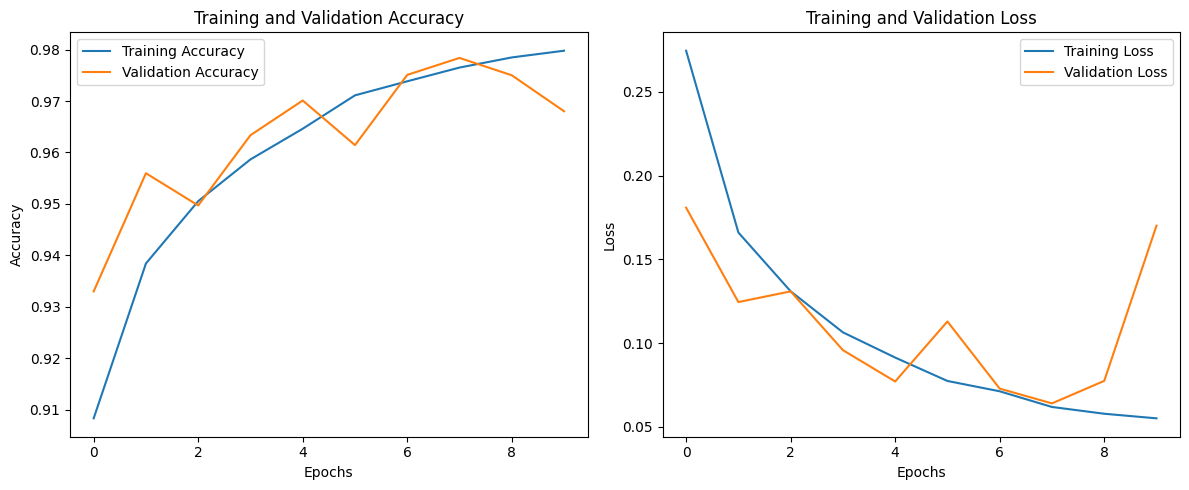

In [66]:
#visualisasikan kurva loss dan akurasi

import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
# Evaluasi performa pada dataset validasi dengan logging hardware performance
import time
import psutil

# Mulai pencatatan waktu evaluasi
start_eval_time = time.time()
val_loss, val_accuracy = model.evaluate(X_test, y_test)
end_eval_time = time.time()

# Logging evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("===========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0390

=== Evaluation Metrics ===
Evaluation Time: 1.56 seconds
Validation Accuracy: 0.978386640548706
Validation Loss: 0.06406302750110626
Memory Usage: 58.4%


Augmentasi Data

In [68]:
# Simpan model saat ini sebagai backup
model.save('student_engagement_model_backup_dgx_16jan.h5')
print("Model saat ini berhasil disimpan sebagai backup.")

Model saat ini berhasil disimpan sebagai backup.


In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dengan Data Augmentation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

# Load Dataset Testing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.


In [70]:
from tensorflow.keras.layers import Dropout

# Tambahkan Dropout Layer utk mencegah overfitting
model.add(Dropout(0.5))  # Dropout tambahan untuk regularisasi
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("Dropout layer berhasil ditambahkan dan model di-compile ulang.")

Dropout layer berhasil ditambahkan dan model di-compile ulang.


In [71]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Gunakan learning rate kecil untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
print("Learning rate berhasil disesuaikan untuk fine-tuning.")

Learning rate berhasil disesuaikan untuk fine-tuning.


In [72]:
#latih model finetuning-nya

from tensorflow.keras.callbacks import EarlyStopping

# Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

# Fine-tuning Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_finetuned_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10


/home/riset/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1556/1556 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.4648 - loss: 8.0977 - precision: 0.8264 - recall: 0.4444 - val_accuracy: 0.9061 - val_loss: 0.4897 - val_precision: 0.8981 - val_recall: 0.9995
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.5055 - loss: 7.9512 - precision: 0.8331 - recall: 0.5016 - val_accuracy: 0.8857 - val_loss: 0.7611 - val_precision: 0.8785 - val_recall: 0.9998
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.5032 - loss: 7.9910 - precision: 0.8276 - recall: 0.5026 - val_accuracy: 0.8759 - val_loss: 0.8753 - val_precision: 0.8693 - val_recall: 0.9998
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.5028 - loss: 7.9943 - precision: 0.8258 - recall: 0.5041 - val_accuracy: 0.8983 - val_loss: 0.5736 - val_precision: 0.8906 - val_recall: 0.9995
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.4966 - loss: 8.0930 - precision: 0.8232 - recall: 0.4957 - val_accuracy: 0.8695 - val

In [73]:
# Evaluasi Model setelah finetuning
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7380 - loss: 1.4113 - precision: 0.6131 - recall: 0.8254
✅ Test Loss: 0.48972460627555847
✅ Test Accuracy: 0.9060742259025574
✅ Precision: 0.8981181383132935
✅ Recall: 0.9995129704475403
✅ F1-Score: 0.9461066239783509


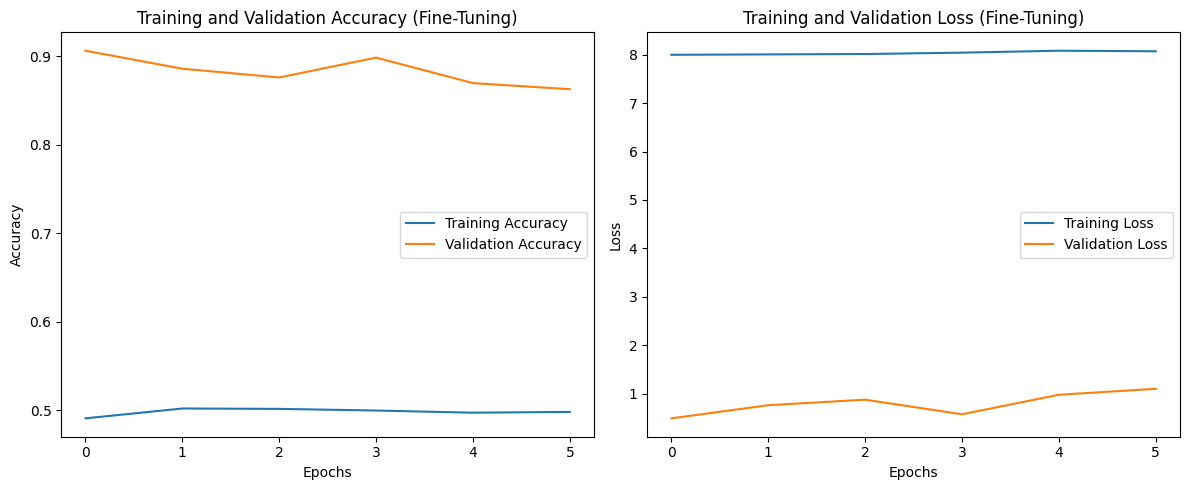

In [74]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
import time
import psutil

# Mulai pencatatan waktu evaluasi
start_eval_time = time.time()
eval_results = model.evaluate(X_test, y_test)
end_eval_time = time.time()

# Logging evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Loss: {eval_results[0]}")
print(f"Validation Accuracy: {eval_results[1]}")
print(f"Validation Precision: {eval_results[2]}")
print(f"Validation Recall: {eval_results[3]}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("=========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9907 - loss: 0.0498 - precision: 0.9903 - recall: 0.9998

=== Evaluation Metrics ===
Evaluation Time: 1.82 seconds
Validation Loss: 0.4900561273097992
Validation Accuracy: 0.9060742259025574
Validation Precision: 0.8981181383132935
Validation Recall: 0.9995129704475403
Memory Usage: 58.4%


In [76]:
# Simpan Model Fine-Tuning
model.save('model_finetuned_pklg_dgx.h5')
print("Model hasil fine-tuning berhasil disimpan.")

Model hasil fine-tuning berhasil disimpan.


In [77]:
#Opsi 1: Freeze Layer Awal

# Simpan model saat ini sebagai backup
model.save('model_before_freeze_pklg_dgx.h5')
print("Model saat ini berhasil disimpan sebagai backup sebelum freeze.")

Model saat ini berhasil disimpan sebagai backup sebelum freeze.


In [78]:
# Freeze semua layer awal model kecuali beberapa layer terakhir
for layer in model.layers[:-4]:  # Freeze semua kecuali 4 layer terakhir
    layer.trainable = False

# Tampilkan status layer apakah trainable atau tidak
for layer in model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

conv2d_7: Trainable = False
max_pooling2d_3: Trainable = False
batch_normalization_3: Trainable = False
conv2d_8: Trainable = False
max_pooling2d_4: Trainable = False
batch_normalization_4: Trainable = False
flatten_1: Trainable = False
dense_2: Trainable = True
dropout_4: Trainable = True
dense_3: Trainable = True
dropout_5: Trainable = True


In [79]:
from tensorflow.keras.optimizers import Adam

# Compile ulang model dengan learning rate yang kecil
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate kecil untuk fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Model berhasil di-compile ulang dengan layer awal dibekukan.")

Model berhasil di-compile ulang dengan layer awal dibekukan.


In [80]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

#train
history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stopping], verbose=1)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_freezelayer_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.5037 - loss: 7.9769 - precision_1: 0.8244 - recall_1: 0.5029 - val_accuracy: 0.8838 - val_loss: 0.7587 - val_precision_1: 0.8768 - val_recall_1: 0.9996
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.4971 - loss: 8.0883 - precision_1: 0.8223 - recall_1: 0.4981 - val_accuracy: 0.8780 - val_loss: 0.8129 - val_precision_1: 0.8712 - val_recall_1: 0.9998
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.4997 - loss: 8.0489 - precision_1: 0.8256 - recall_1: 0.4981 - val_accuracy: 0.8780 - val_loss: 0.8309 - val_precision_1: 0.8712 - val_recall_1: 0.9998
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.5028 - loss: 7.9981 - precision_1: 0.8242 - recall_1: 0.5047 - val_accuracy: 0.8641 - val_loss: 1.0257 - val_precision_1: 0.8586 - val_recall_1: 0.9999
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 5

In [81]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f" Test Loss: {loss}")
print(f" Test Accuracy: {accuracy}")
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6735 - loss: 2.2655 - precision_1: 0.5841 - recall_1: 0.8255
 Test Loss: 0.7587481737136841
 Test Accuracy: 0.8838180899620056
 Precision: 0.8767942786216736
 Recall: 0.9996103644371033
 F1-Score: 0.9341829385494407


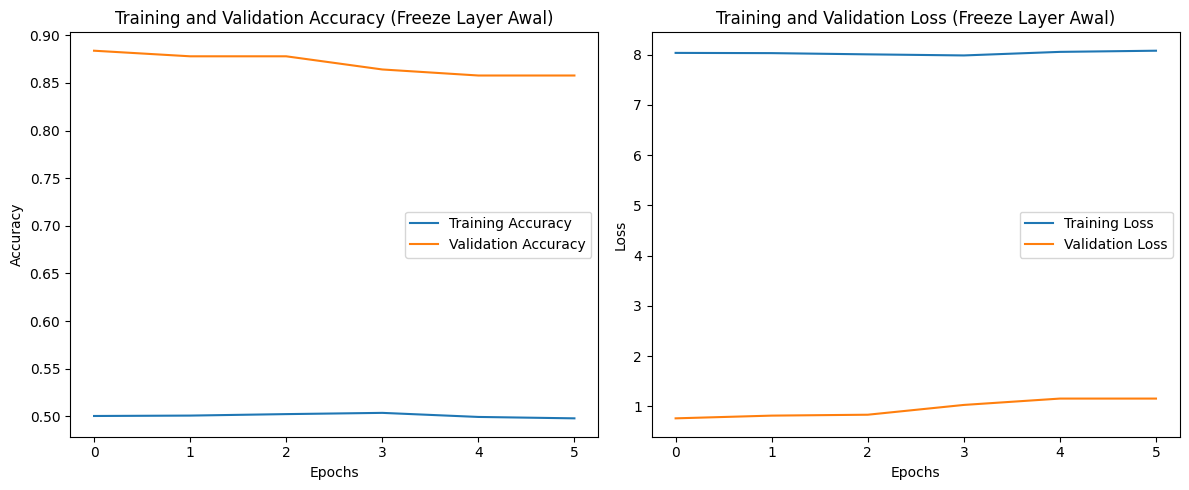

In [82]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Freeze Layer Awal)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Freeze Layer Awal)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# Simpan Model Fine-Tuning
model.save('model_finetuned_freeze_layers_pklg_dgx.h5')
print("✅ Model hasil fine-tuning berhasil disimpan.")

✅ Model hasil fine-tuning berhasil disimpan.


In [84]:
#Opsi 2: Learning Rate Scheduler

from tensorflow.keras.models import load_model

# Muat model backup sebelum freeze
model = load_model('baseline_retraining_pklg_dgx.h5')
print("Model berhasil dimuat ulang dari backup sebelum freeze.")

Model berhasil dimuat ulang dari backup sebelum freeze.


In [85]:
# Periksa status trainable setiap layer
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} | Trainable = {layer.trainable}")

Layer 0: conv2d_7 | Trainable = True
Layer 1: max_pooling2d_3 | Trainable = True
Layer 2: batch_normalization_3 | Trainable = True
Layer 3: conv2d_8 | Trainable = True
Layer 4: max_pooling2d_4 | Trainable = True
Layer 5: batch_normalization_4 | Trainable = True
Layer 6: flatten_1 | Trainable = True
Layer 7: dense_2 | Trainable = True
Layer 8: dropout_4 | Trainable = True
Layer 9: dense_3 | Trainable = True


In [86]:
from tensorflow.keras.optimizers import Adam

# Compile ulang model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate awal
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Model berhasil di-compile ulang dengan konfigurasi awal.")

Model berhasil di-compile ulang dengan konfigurasi awal.


In [87]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Fungsi Scheduler: Menyesuaikan Learning Rate berdasarkan Epoch
def scheduler(epoch, lr):
    if epoch < 3:
        return lr  # Pertahankan learning rate awal selama 3 epoch pertama
    else:
        return lr * 0.1  # Turunkan learning rate 10x lipat setelah epoch ke-3

# Inisialisasi Callback Scheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

print("Learning Rate Scheduler berhasil diinisialisasi.")

Learning Rate Scheduler berhasil diinisialisasi.


In [88]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile Model dengan Learning Rate Awal
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Model berhasil di-compile ulang dengan learning rate awal 0.001.")

Model berhasil di-compile ulang dengan learning rate awal 0.001.


In [89]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

# Fine-tuning Model dg scheduler
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_lrate_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.7983 - loss: 0.7589 - precision_3: 0.8341 - recall_3: 0.9423 - val_accuracy: 0.8678 - val_loss: 0.3320 - val_precision_3: 0.8622 - val_recall_3: 0.9995
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8619 - loss: 0.3754 - precision_3: 0.8650 - recall_3: 0.9861 - val_accuracy: 0.8805 - val_loss: 0.3147 - val_precision_3: 0.8758 - val_recall_3: 0.9964
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8747 - loss: 0.3468 - precision_3: 0.8779 - recall_3: 0.9853 - val_accuracy: 0.8780 - val_loss: 0.3236 - val_precision_3: 0.8717 - val_recall_3: 0.9991
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8810 - loss: 0.3267 - precision_3: 0.8852 - recall_3: 0.9835 - val_accuracy: 0.9018 - val_loss: 0.2812 - val_precision_3: 0.9023 - val_recall_3: 0.9879
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 5

In [90]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8040 - loss: 0.4281 - precision_3: 0.6297 - recall_3: 0.7805
Test Loss: 0.2505894601345062
Test Accuracy: 0.9079222083091736
Precision: 0.9140185117721558
Recall: 0.9806156158447266
F1-Score: 0.946146557208905


In [91]:
from sklearn.metrics import f1_score

# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8040 - loss: 0.4281 - precision_3: 0.6297 - recall_3: 0.7805
Test Loss: 0.2505894601345062
Test Accuracy: 0.9079222083091736
Precision: 0.9140185117721558
Recall: 0.9806156158447266
F1-Score: 0.946146557208905


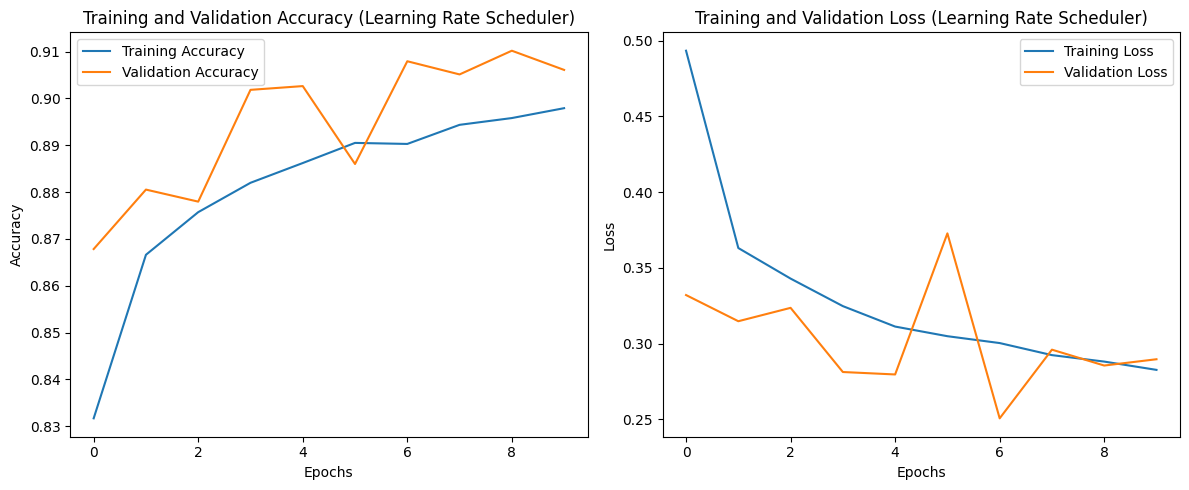

In [92]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Learning Rate Scheduler)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Learning Rate Scheduler)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
import time
import psutil

# Mulai pencatatan waktu evaluasi
start_eval_time = time.time()
eval_results = model.evaluate(X_test, y_test)
end_eval_time = time.time()

# Logging evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Loss: {eval_results[0]}")
print(f"Validation Accuracy: {eval_results[1]}")
print(f"Validation Precision: {eval_results[2]}")
print(f"Validation Recall: {eval_results[3]}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("=========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9734 - loss: 0.1302 - precision_3: 0.9919 - recall_3: 0.9805

=== Evaluation Metrics ===
Evaluation Time: 1.69 seconds
Validation Loss: 0.2507030665874481
Validation Accuracy: 0.9079222083091736
Validation Precision: 0.9140185117721558
Validation Recall: 0.9806156158447266
Memory Usage: 58.4%


In [94]:
# Simpan Model Fine-Tuning dengan Scheduler
model.save('model_finetuned_scheduler_pklg_dgx.h5')
print("✅ Model hasil fine-tuning dengan scheduler berhasil disimpan.")

✅ Model hasil fine-tuning dengan scheduler berhasil disimpan.


In [95]:
#Opsi 3: Pake Model Pretrained

from tensorflow.keras.models import load_model

# Muat model backup sebelum freeze
model = load_model('baseline_retraining_pklg_dgx.h5')
print("Model berhasil dimuat ulang dari backup sebelum freeze.")

Model berhasil dimuat ulang dari backup sebelum freeze.


In [96]:
# Pastikan dataset sesuai dengan input MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dan Testing
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resolusi input MobileNetV2
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'  # MobileNetV2 membutuhkan 3 channel
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("Dataset siap untuk digunakan dengan MobileNetV2.")

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.
Dataset siap untuk digunakan dengan MobileNetV2.


In [97]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load MobileNetV2 sebagai Feature Extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan Layer Kustom di Atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk mengurangi dimensi
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularisasi untuk mencegah overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output biner

# Bangun Model Akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan Ringkasan Model
model.summary()
print("Model MobileNetV2 berhasil disiapkan dan di-compile.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model MobileNetV2 berhasil disiapkan dan di-compile.


In [98]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

# latih model dengan mobilenetv2
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_mobilenetv2_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10


/home/riset/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737017216.908706   19616 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1668', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1737017216.993023   19634 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1668', 228 bytes spill stores, 228 bytes spill loads



 510/1556 ━━━━━━━━━━━━━━━━━━━━ 4:38 266ms/step - accuracy: 0.8273 - loss: 0.4374 - precision_4: 0.8410 - recall_4: 0.9741

I0000 00:00:1737017358.176946   19725 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1668', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1737017358.298150   19722 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1668', 224 bytes spill stores, 224 bytes spill loads



1554/1556 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8483 - loss: 0.3910 - precision_4: 0.8568 - recall_4: 0.9798

I0000 00:00:1737017657.718625   19910 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1183', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1737017657.804672   19898 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1183', 248 bytes spill stores, 248 bytes spill loads



1556/1556 ━━━━━━━━━━━━━━━━━━━━ 451s 283ms/step - accuracy: 0.8484 - loss: 0.3909 - precision_4: 0.8568 - recall_4: 0.9798 - val_accuracy: 0.8966 - val_loss: 0.2678 - val_precision_4: 0.8927 - val_recall_4: 0.9942
Epoch 2/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 430s 275ms/step - accuracy: 0.8936 - loss: 0.2893 - precision_4: 0.8978 - recall_4: 0.9829 - val_accuracy: 0.9164 - val_loss: 0.2431 - val_precision_4: 0.9191 - val_recall_4: 0.9854
Epoch 3/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 433s 277ms/step - accuracy: 0.9034 - loss: 0.2644 - precision_4: 0.9084 - recall_4: 0.9816 - val_accuracy: 0.9230 - val_loss: 0.2268 - val_precision_4: 0.9231 - val_recall_4: 0.9891
Epoch 4/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 431s 276ms/step - accuracy: 0.9109 - loss: 0.2476 - precision_4: 0.9160 - recall_4: 0.9823 - val_accuracy: 0.9258 - val_loss: 0.2143 - val_precision_4: 0.9298 - val_recall_4: 0.9844
Epoch 5/10
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 437s 280ms/step - accuracy: 0.9132 - loss: 0.2398 - precision_4: 0.9183 -

In [99]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f" Test Loss: {loss}")
print(f" Test Accuracy: {accuracy}")
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8532 - loss: 0.3348 - precision_4: 0.6665 - recall_4: 0.8160
 Test Loss: 0.1892135888338089
 Test Accuracy: 0.93467777967453
 Precision: 0.9332661032676697
 Recall: 0.9917202591896057
 F1-Score: 0.9616056215211215


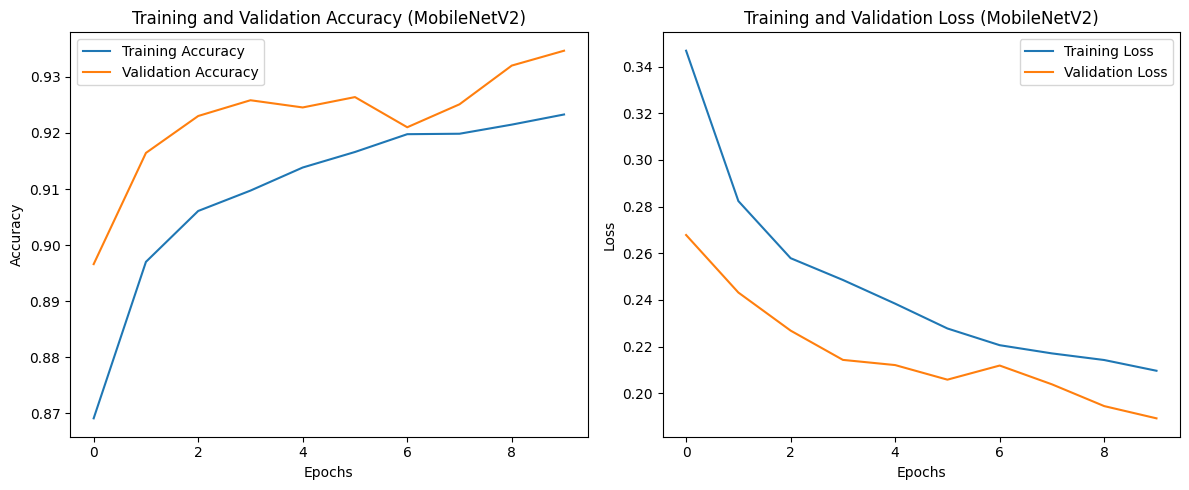

In [100]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
# Evaluasi model menggunakan test_generator
start_eval_time = time.time()
eval_results = model.evaluate(test_generator)
end_eval_time = time.time()

# Logging hasil evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Loss: {eval_results[0]}")
print(f"Validation Accuracy: {eval_results[1]}")
print(f"Validation Precision: {eval_results[2]}")
print(f"Validation Recall: {eval_results[3]}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("===========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8532 - loss: 0.3348 - precision_4: 0.6665 - recall_4: 0.8160

=== Evaluation Metrics ===
Evaluation Time: 19.74 seconds
Validation Loss: 0.1892135888338089
Validation Accuracy: 0.93467777967453
Validation Precision: 0.9332661032676697
Validation Recall: 0.9917202591896057
Memory Usage: 59.2%


In [102]:
# Simpan Model
model.save('model_mobilenetv2_pklg_dgx.h5')
print(" Model MobileNetV2 berhasil disimpan.")

 Model MobileNetV2 berhasil disimpan.


In [103]:
#Opsi 4: Pake model Resnet50

from tensorflow.keras.models import load_model

# Muat model backup baseline
model = load_model('baseline_retraining_pklg_dgx.h5')
print("Model berhasil dimuat ulang dari backup sebelum freeze.")

Model berhasil dimuat ulang dari backup sebelum freeze.


In [104]:
# Tampilkan ringkasan model sebelum freeze layer tadi
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 838,659 (3.20 MB)

 Trainable params: 838,465 (3.20 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data pake resnet50
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dan Testing
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print(" Dataset siap untuk digunakan dengan ResNet50.")

Found 49777 images belonging to 2 classes.
Found 12446 images belonging to 2 classes.
 Dataset siap untuk digunakan dengan ResNet50.


In [106]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 sebagai Feature Extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal untuk mempertahankan fitur pretrained
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan Layer Kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mengurangi dimensi fitur
x = Dense(128, activation='relu')(x)  # Layer Dense untuk klasifikasi
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output untuk klasifikasi biner

# Bangun Model Akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan Ringkasan Model
model.summary()
print(" Model ResNet50 berhasil disiapkan dan di-compile ulang.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Model ResNet50 berhasil disiapkan dan di-compile ulang.


In [107]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback untuk ModelCheckpoint (Format .keras)
checkpoint = ModelCheckpoint(
    'checkpoint_resnet50.keras',  # Ubah ekstensi ke .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(" Callback EarlyStopping dan ModelCheckpoint (.keras format) telah diatur.")

 Callback EarlyStopping dan ModelCheckpoint (.keras format) telah diatur.


In [108]:
# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

# latih model dengan resnet50
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_resnet_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10


/home/riset/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737021900.845711   21836 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5681', 4820 bytes spill stores, 5616 bytes spill loads



1006/1556 ━━━━━━━━━━━━━━━━━━━━ 2:28 270ms/step - accuracy: 0.8254 - loss: 0.4793 - precision_5: 0.8289 - recall_5: 0.9945

I0000 00:00:1737022177.458109   21924 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5681', 244 bytes spill stores, 244 bytes spill loads



1555/1556 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8248 - loss: 0.4759 - precision_5: 0.8274 - recall_5: 0.9961

I0000 00:00:1737022344.470786   22108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1712', 244 bytes spill stores, 244 bytes spill loads




Epoch 1: val_loss improved from inf to 0.44786, saving model to checkpoint_resnet50.keras
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 456s 285ms/step - accuracy: 0.8248 - loss: 0.4759 - precision_5: 0.8274 - recall_5: 0.9961 - val_accuracy: 0.8248 - val_loss: 0.4479 - val_precision_5: 0.8248 - val_recall_5: 1.0000
Epoch 2/10
1555/1556 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8276 - loss: 0.4553 - precision_5: 0.8276 - recall_5: 1.0000
Epoch 2: val_loss improved from 0.44786 to 0.44004, saving model to checkpoint_resnet50.keras
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 442s 283ms/step - accuracy: 0.8276 - loss: 0.4554 - precision_5: 0.8276 - recall_5: 1.0000 - val_accuracy: 0.8248 - val_loss: 0.4400 - val_precision_5: 0.8248 - val_recall_5: 1.0000
Epoch 3/10
1555/1556 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8270 - loss: 0.4502 - precision_5: 0.8270 - recall_5: 1.0000
Epoch 3: val_loss improved from 0.44004 to 0.43436, saving model to checkpoint_resnet50.keras
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 42

In [109]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f" Test Loss: {loss}")
print(f" Test Accuracy: {accuracy}")
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1-Score: {f1}")

389/389 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5216 - loss: 0.8071 - precision_5: 0.5216 - recall_5: 0.8256
 Test Loss: 0.4191131293773651
 Test Accuracy: 0.8248433470726013
 Precision: 0.8248433470726013
 Recall: 1.0
 F1-Score: 0.9040154632396638


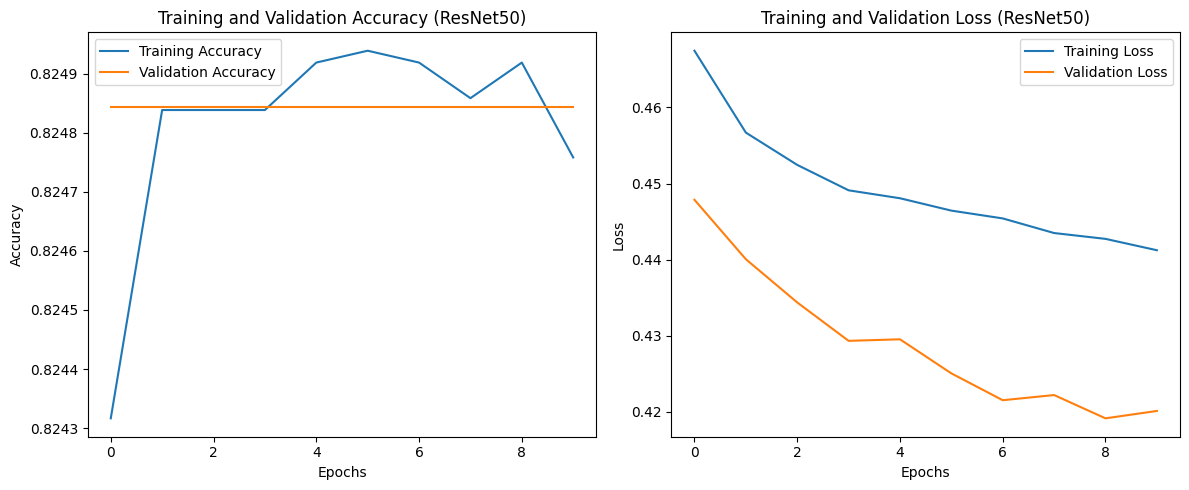

In [110]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
model.save('model_resnet50_pklg_dgx.keras')
print(" Model berhasil disimpan sebagai 'student_engagement_resnet50_final_gpu.keras'")

 Model berhasil disimpan sebagai 'student_engagement_resnet50_final_gpu.keras'


In [112]:
# Evaluasi model menggunakan test_generator
start_eval_time = time.time()
eval_results = model.evaluate(test_generator)
end_eval_time = time.time()

# Logging hasil evaluasi
print("\n=== Evaluation Metrics ===")
print(f"Evaluation Time: {end_eval_time - start_eval_time:.2f} seconds")
print(f"Validation Loss: {eval_results[0]}")
print(f"Validation Accuracy: {eval_results[1]}")
print(f"Validation Precision: {eval_results[2]}")
print(f"Validation Recall: {eval_results[3]}")

# Logging penggunaan memori
memory_info = psutil.virtual_memory()
print(f"Memory Usage: {memory_info.percent}%")
print("===========================")

389/389 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.5216 - loss: 0.8071 - precision_5: 0.5216 - recall_5: 0.8256

=== Evaluation Metrics ===
Evaluation Time: 12.72 seconds
Validation Loss: 0.4191131293773651
Validation Accuracy: 0.8248433470726013
Validation Precision: 0.8248433470726013
Validation Recall: 1.0
Memory Usage: 59.4%


In [7]:
#Opsi 5: Pake model EfficientNet

from tensorflow.keras.models import load_model

# Muat model backup baseline
model = load_model('baseline_retraining_pklg_dgx.h5')
print("Model berhasil dimuat ulang dari backup sebelum freeze.")

2025-01-16 21:07:40.244770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38151 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:87:00.0, compute capability: 8.0


Model berhasil dimuat ulang dari backup sebelum freeze.


In [9]:
from tensorflow.keras.metrics import Precision, Recall

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 sebagai Feature Extractor
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan ringkasan model
model.summary()
print(" EfficientNetB0 berhasil diinisialisasi dan di-compile ulang.")

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 EfficientNetB0 berhasil diinisialisasi dan di-compile ulang.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback untuk EarlyStopping dan ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'checkpoint_model.keras',  # Nama file untuk menyimpan model lengkap
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Mulai logging perangkat
device_used = log_device_info()
start_time = time.time()

# latih model dengan efficientnetb0
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Logging performa setelah pelatihan
log_performance(start_time)

# Menyimpan log performa ke file
with open('device_performance_log_efficientnetb0_dgx.txt', 'a') as log_file:
    log_file.write(f"Device: {device_used}\n")
    log_file.write(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    log_file.write(f"Validation Accuracy: {history.history['val_accuracy'][-1]}\n")
    log_file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    log_file.write("="*30 + "\n")

=== Device Information ===
GPU: NVIDIA A100-SXM4-40GB, Memory: nanMB
Epoch 1/10


ValueError: Input 0 of layer "functional_13" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 48, 48, 3)

In [ ]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f" Test Loss: {loss}")
print(f" Test Accuracy: {accuracy}")
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1-Score: {f1}")

# Visualisasi Kurva Akurasi dan Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()